#### **This notebook explores the replies**

In [1]:
import pandas as pd
import numpy as np
import datetime
import warnings
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as pltc
import sys
import os

import importlib

#### packages
import helper.strategy_helper as st
import helper.visualization as viz_hp
import helper.helper as hp
import helper.file_helper as file_hp
import config.config as config_hp
import helper.pandas_helper as pd_hp

##### **Load config files**

In [2]:
config = config_hp.config()
path = config['PATHS']

derived_path = path['derived_path']
all_tweet_data = path['all_tweet_data']
plot_path = path['plot_path']
external_reply = path['external_reply']
conversation_ids_5 = path['conversation_ids_5']

##### **Read files**

In [3]:
df_external = pd.read_pickle(external_reply)

In [4]:
df_external.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21427154 entries, 0 to 21427153
Data columns (total 9 columns):
 #   Column           Dtype  
---  ------           -----  
 0   replier_tweetid  int64  
 1   replier_userid   object 
 2   poster_tweetid   float64
 3   poster_userid    float64
 4   tweet_language   object 
 5   tweet_text       object 
 6   tweet_time       object 
 7   year             object 
 8   campaign         object 
dtypes: float64(2), int64(1), object(6)
memory usage: 1.4+ GB


In [5]:
df_external = df_external.astype({
    'poster_tweetid': int,
})

df_external = df_external.astype({
    'poster_tweetid': str,
    'poster_userid': str
})

In [6]:
poster_tweetids = file_hp.read_file(conversation_ids_5)

In [7]:
df_all_5 = df_external.loc[
    df_external['poster_tweetid'].isin(poster_tweetids)]

df_all_5['tweet_time'] =  pd.to_datetime(
    df_all_5['tweet_time'])
df_all_5 = df_all_5.drop_duplicates(subset=['replier_tweetid'], 
                                keep='last')
df_all_5 = df_all_5.sort_values(by=['tweet_time'], 
                    ascending=True).drop_duplicates()

/tmp/ipykernel_1308766/3949000814.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all_5['tweet_time'] =  pd.to_datetime(


##### **RQ1: Time duration between replies** <br />
This includes all the replies whether the poster tweets are alive or not

**1 sec is added to all the time diff to account for the zero time difference**

In [8]:
df_all_5['diff'] = df_all_5.groupby('poster_tweetid')['tweet_time'].diff()
df_5 = df_all_5.dropna(subset=['diff'])
df_5['diff'] = df_5['diff'] + datetime.timedelta(seconds=1)

df_5['diff_min'] = df_5['diff'].apply(
    lambda x: int(np.ceil((x.total_seconds() + 1) / 3600)))
df_5 = df_5.loc[df_5['diff_min'] >= 1]

print('Min time diff :', df_5['diff'].min())
print('Max time diff :', df_5['diff'].max())

print('Total unique conversations :', df_5['poster_tweetid'].nunique())
print('Total data points with time difference data :', len(df_5))
print('Time difference in consecutive replying less than 60 min filtering :', 
      len(df_5.loc[df_5['diff'] <= datetime.timedelta(minutes=60)]))

/tmp/ipykernel_1308766/3822694540.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_5['diff'] = df_5['diff'] + datetime.timedelta(seconds=1)
/tmp/ipykernel_1308766/3822694540.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_5['diff_min'] = df_5['diff'].apply(


Min time diff : 0 days 00:00:01
Max time diff : 1476 days 23:44:01
Total unique conversations : 96041
Total data points with time difference data : 1368806
Time difference in consecutive replying less than 60 min filtering : 1196845


In [9]:
print('Minimum diff in time in  hour: ', 
      df_5['diff_min'].min())
print('Maximum diff in time in hour: ',
      df_5['diff_min'].max())

Minimum diff in time in  hour:  1.0
Maximum diff in time in hour:  35448.0


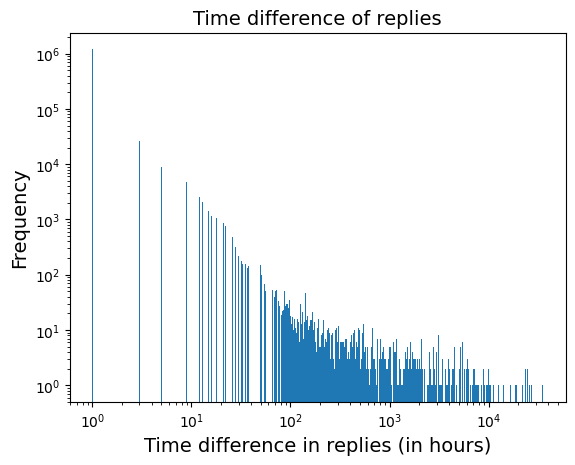

In [10]:
plot_path = path['plot_path']
reply_plot_path = file_hp.create_folder(plot_path, 
                                        'reply_characterization')
df_no_zero = df_5.loc[(df_5['diff_min'] > 0)]

parameters =  {
        'data': df_no_zero,
        'fontsize': 14,
        'columns': [
            {'column': 'diff_min',
             'label': 'Difference reply time in hours',
            }
        ],
        'xlabel': 'Time difference in replies (in hours)',
        'ylabel': 'Frequency',
        'legend_location': '',
        'log_yscale': True,
        'log_xscale': True,
        'bins': None,
        'save': {
            'path': reply_plot_path,
            'filename': 'time_difference_between_replies.png'
        },
        'title': 'Time difference of replies'
    }

viz_hp.plot_histogram(parameters)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


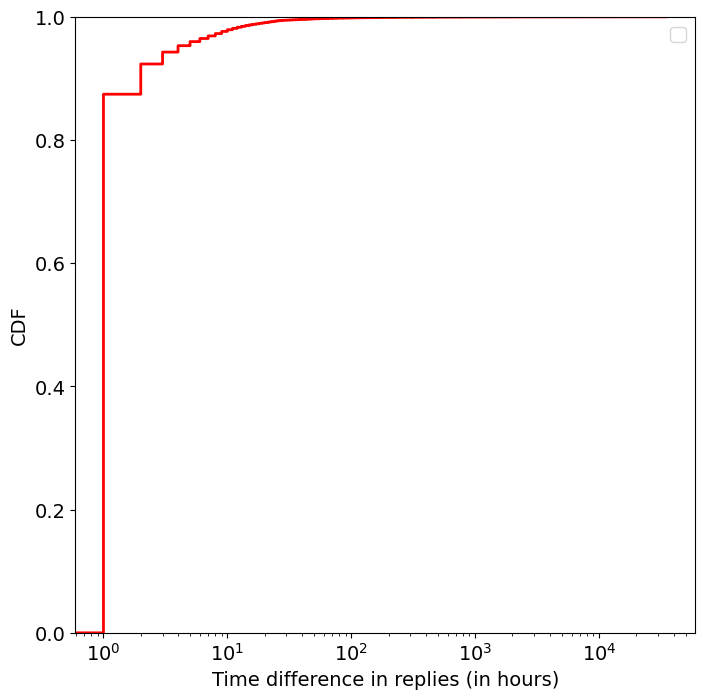

In [11]:
parameters = {
        'data': [df_no_zero],
        'fontsize': 14,
        'complementary': False,
        'columns': [
            {'column': 'diff_min',
             'label': '',
            },{
            'column': '',
             'label': ''
            }
        ],
        'xlabel': 'Time difference in replies (in hours)',
        'ylabel': 'CDF',
        'legend_location': 'upper right',
        # 'log_yscale': False,
        'log_xscale': True,
        'save': {
            'path': reply_plot_path,
            'filename': 'ccdf_time_difference_between_replies.png'
        },
        'random_color': False
    }

viz_hp.ccdf(parameters)

 40% of the replies are within an day, 60% of data are within 2 hours

In [12]:
## For alive tweets
config = config_hp.config()
poster_path = config['POSTER_PATH']
poster_org_tweets = poster_path['parsed_poster_org_tweets']

In [13]:
df_org = pd.read_pickle(poster_org_tweets)

print(df_org.columns)

Index(['text', 'conversation_id', 'lang', 'entities', 'possibly_sensitive',
       'reply_settings', 'created_at', 'edit_history_tweet_ids', 'tweetid',
       'author_id', 'retweet_count', 'reply_count', 'like_count',
       'quote_count', 'impression_count', 'expanded_url', 'display_url',
       'in_reply_to_user_id', 'referenced_tweets', 'context_annotations',
       'entity_annotations', 'cashtags', 'hashtags', 'mentions'],
      dtype='object')


In [14]:
df_alive = df_5.loc[df_5['poster_tweetid'].isin(df_org['tweetid'])]

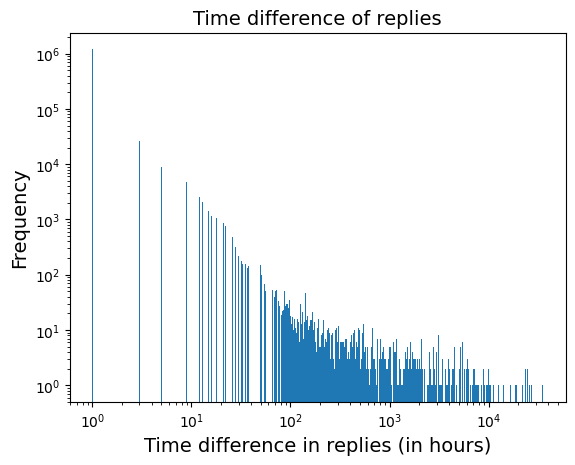

In [15]:
plot_path = path['plot_path']
reply_plot_path = file_hp.create_folder(plot_path, 
                                        'reply_characterization')
df_no_zero_live = df_alive.loc[~(df_alive['diff_min'] == 0)]

parameters =  {
        'data': df_no_zero_live,
        'fontsize': 14,
        'columns': [
            {'column': 'diff_min',
             'label': 'Difference reply time in hours',
            }
        ],
        'xlabel': 'Time difference in replies (in hours)',
        'ylabel': 'Frequency',
        'legend_location': '',
        'log_yscale': True,
        'log_xscale': True,
        'bins': None,
        'save': {
            'path': reply_plot_path,
            'filename': 'time_difference_alive_between_replies.png'
        },
        'title': 'Time difference of replies'
    }

viz_hp.plot_histogram(parameters)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


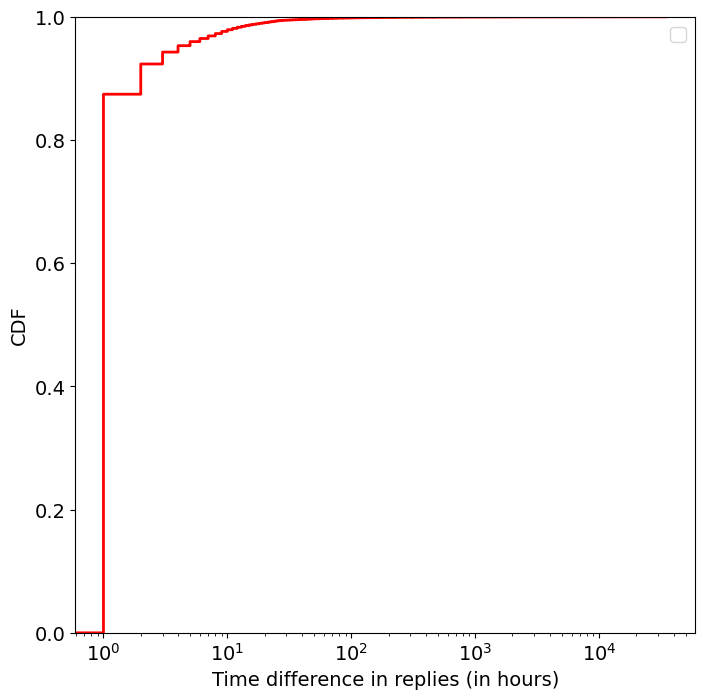

In [16]:
parameters = {
        'data': [df_no_zero_live],
        'fontsize': 14,
        'complementary': False,
        'columns': [
            {'column': 'diff_min',
             'label': '',
            },{
            'column': '',
             'label': ''
            }
        ],
        'xlabel': 'Time difference in replies (in hours)',
        'ylabel': 'CDF',
        'legend_location': 'upper right',
        # 'log_yscale': False,
        'log_xscale': True,
        'save': {
            'path': reply_plot_path,
            'filename': 'ccdf_time_difference_between_alive_tweet_replies.png'
        },
        'random_color': False
    }

viz_hp.ccdf(parameters)

In [50]:
df_no_zero_live.sort_values(by=['diff_min'],
                        ascending=True
                       )['diff_min'].head()

20982144    1.0
6761367     1.0
2826334     1.0
6736783     1.0
6732856     1.0
Name: diff_min, dtype: float64

##### **RQ2: Time difference between poster tweet and first/last reply**

In [17]:
## For alive tweets
config = config_hp.config()
poster_path = config['POSTER_PATH']
poster_org_tweets = poster_path['parsed_poster_org_tweets']
poster_alive_file = poster_path['poster_alive_file']

In [ ]:
df_poster_tweets = pd.read_pickle(poster_org_tweets)
df_poster_tweets = df_poster_tweets.loc[
    ~df_poster_tweets['author_id'].isna()]

In [ ]:
alive_poster = file_hp.read_file(poster_alive_file)

In [ ]:
df_all_5.columns

Index(['replier_tweetid', 'replier_userid', 'poster_tweetid', 'poster_userid',
       'tweet_language', 'tweet_text', 'tweet_time', 'year', 'campaign',
       'diff'],
      dtype='object')

In [ ]:
df_poster_reply = df_poster_tweets[
    ['author_id', 'created_at', 'tweetid']].merge(
    df_all_5[['replier_userid', 
              'poster_tweetid',
              'tweet_time']],
    left_on=['tweetid'],
    right_on=['poster_tweetid'])

In [ ]:
df_poster_reply = df_poster_reply.astype({
    'author_id': str
})

In [ ]:
df_poster_reply = df_poster_reply.loc[
    df_poster_reply['author_id'].isin(alive_poster)]

In [ ]:
df_poster_reply = df_poster_reply.sort_values(
    by=['created_at', 'tweet_time'])

In [40]:
df_last = df_poster_reply.groupby(
    ['tweetid']).tail(1).reset_index(drop=True)

df_last['created_at'] = pd.to_datetime(df_last['created_at'])
df_last['created_at'] = df_last['created_at'].apply(
    lambda x: x.replace(tzinfo=None))

df_last['tweet_time'] = pd.to_datetime(df_last['tweet_time'])
df_last['diff'] = df_last['tweet_time'] - df_last['created_at']
df_last['diff_min'] = df_last['diff'].apply(
    lambda x: int(np.ceil((x.total_seconds() + 1)/ 3600 )))
df_last = df_last.loc[df_last['diff_min'] >=1]

print('Minimum time diff :', df_last['diff_min'].min())
print('Maximum time diff :', df_last['diff_min'].max())

Minimum time diff : 1
Maximum time diff : 56004


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


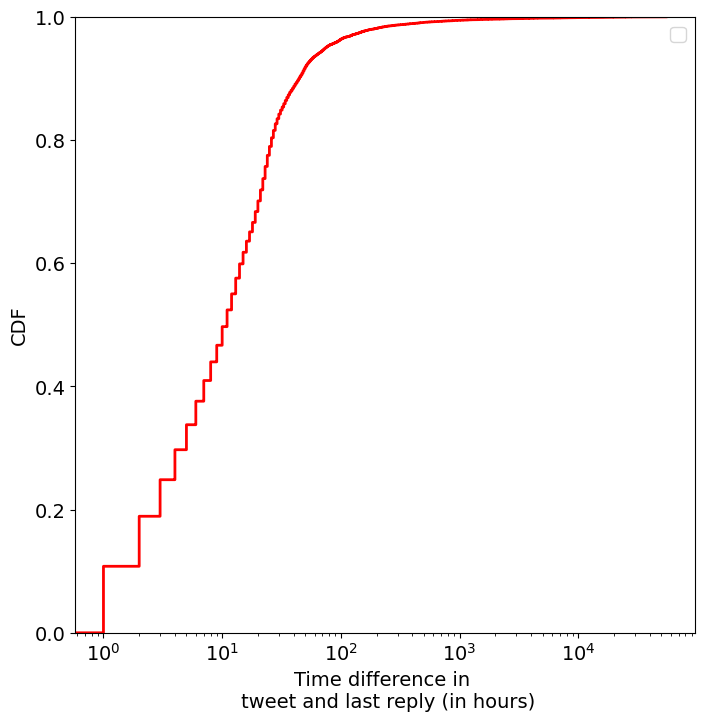

In [41]:
parameters = {
        'data': [df_last],
        'fontsize': 14,
        'complementary': False,
        'columns': [
            {'column': 'diff_min',
             'label': '',
            },{
            'column': '',
             'label': ''
            }
        ],
        'xlabel': 'Time difference in \n tweet and last reply (in hours)',
        'ylabel': 'CDF',
        'legend_location': 'upper right',
        # 'log_yscale': False,
        'log_xscale': True,
        'save': {
            'path': reply_plot_path,
            'filename': 'ccdf_time_difference_tweet_last_reply.png'
        },
        'random_color': False
    }

viz_hp.ccdf(parameters)

In [42]:
df_last['diff_min'].min()

1

In [51]:
df_last.sort_values(['diff_min'],
                                ascending=True
                               )['diff_min'].head()

27994    1
9109     1
17200    1
17198    1
17195    1
Name: diff_min, dtype: int64

In [ ]:
# df_poster_reply.loc[935564253163028480

##### **RQ3: Similarity in reply semantics**
Pairwise cosine similairty in embeddings of reply

In [ ]:
embedding_path = config['EMBEDDINGS_PATH']
reply_english_cosine = embedding_path['reply_english_cosine']

In [ ]:
df_cosine = pd.read_pickle(reply_english_cosine)

In [55]:
df_cosine.columns

Index(['poster_tweetid', 'cosine', 'mean_cosine'], dtype='object')

In [52]:
df_cosine['mean_cosine'] = df_cosine['cosine'].apply(
    lambda x: np.mean(x))

In [54]:
print('Min value mean cosine :',
      df_cosine['mean_cosine'].min())
print('Max value mean cosisne :', 
      df_cosine['mean_cosine'].max())

Min value mean cosine : 0.37
Max value mean cosisne : 1.0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


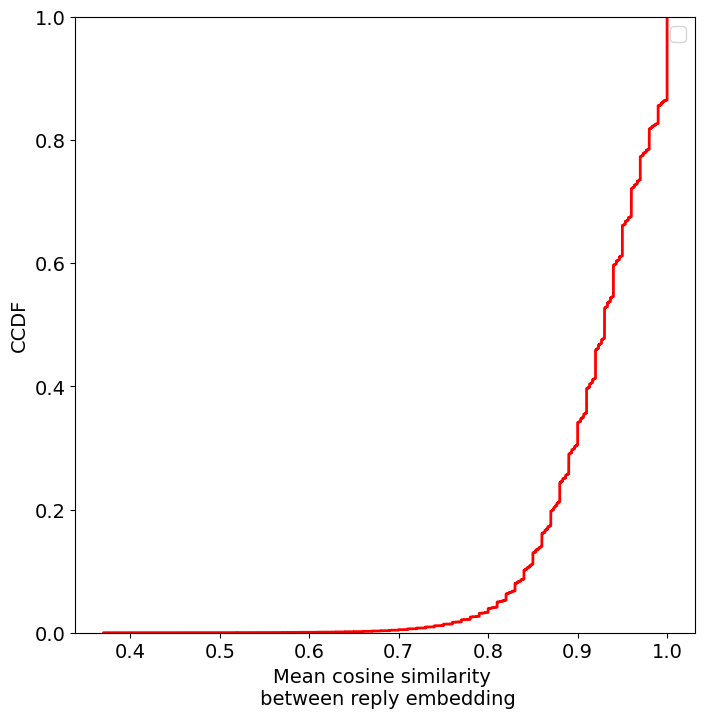

In [59]:
parameters = {
        'data': [df_cosine],
        'fontsize': 14,
        'complementary': False,
        'columns': [
            {'column': 'mean_cosine',
             'label': '',
            },{
            'column': '',
             'label': ''
            }
        ],
        'xlabel': 'Mean cosine similarity \n between reply embedding',
        'ylabel': 'CCDF',
        'legend_location': 'upper right',
        # 'log_yscale': False,
        # 'log_xscale': True,
        'save': {
            'path': reply_plot_path,
            'filename': 'ccdf_reply_embeddings.png'
        },
        'random_color': False
    }

viz_hp.ccdf(parameters)

#### **Similarity in post and the reply pairwise**

#### **Time difference in reply for coordinated and non coordinated repliers (That means each tweet has full conversations)**

In [ ]:
### How many people not in IO replied to tweets?